# Проект по Основам Машинного Обучения. 

## Задачи исследования.

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;

    2) предложить меры по снижению оттока;

    3) определить другие особенности взаимодействия с клиентами.

## Загрузка библиотек и подготовка данных.

In [2]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/gym_churn.csv')

Посмотрим на общую информацию по датафрейму:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

По общим данным:
* Всего в датафрейме 4000 строк
* Пропусков в строках нет
* Формат данных в датафрейме нормальный
* Названия столбцов надо немного скорректировать, а именно привести к нижнему регистру.

In [5]:
df.columns = [i.lower() for i in df]

In [6]:
df.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

In [7]:
df.duplicated().sum()

0

## Исследовательский анализ данных(EDA)

Проверим данные по датафрейму методом `describe()`:

In [31]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Выводы по датафрейму:
* Соотношение полов примерно одинаковое
* Большая часть пользователей проживает в районе с фитнес-центром
* Почти половина - партнеры клуба
* 90% пользователей оставили свой номер телефона
* В среднем у половины клиентов контракт не более, чем на 1 месяц.
* Возврастные группа от 18 до 41 года
* В среднем клиенты подписали контракт примерно 4 месяца назад, но есть и клиенты, которые с клубом почти 3 года


In [32]:
def highlight_min(x):
    is_min = x == x.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

In [33]:
df.groupby('churn').agg('mean').T.style.apply(highlight_min, axis = 1)

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Построим графики распределения для всех признаков. Проанализируем данные из графиков, чтобы выявить признак, который больше всего влияет на отток.

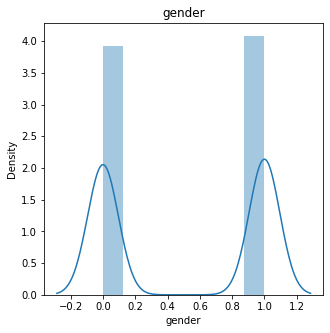

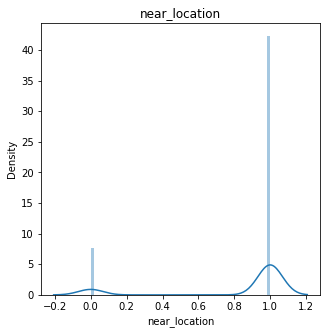

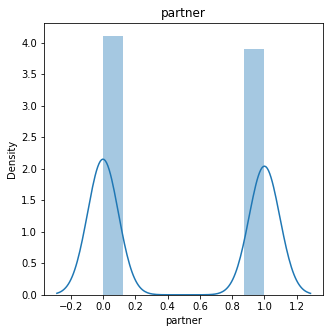

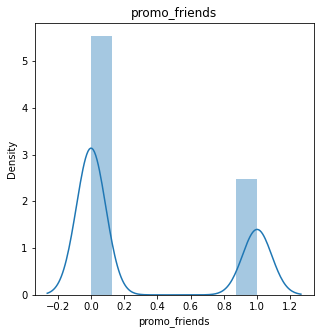

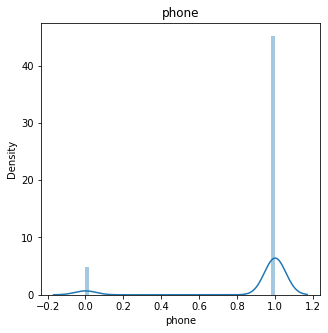

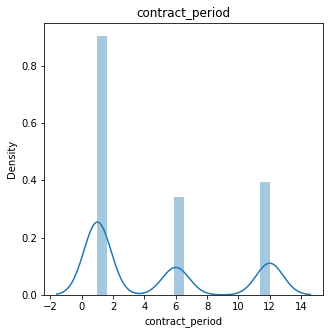

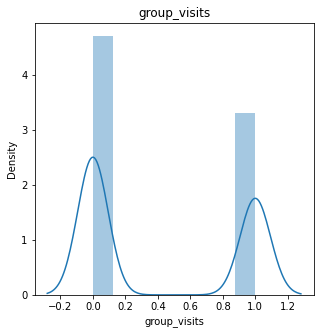

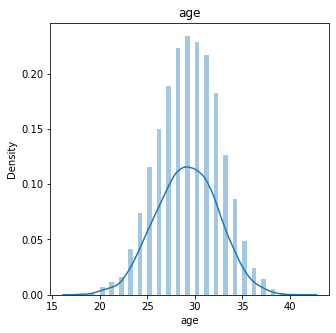

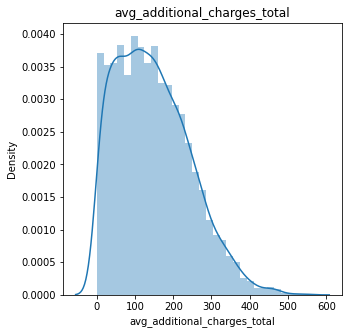

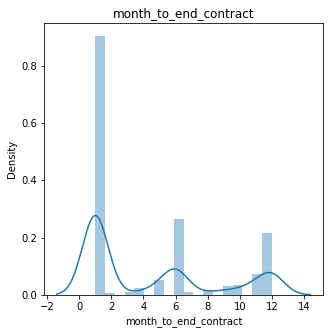

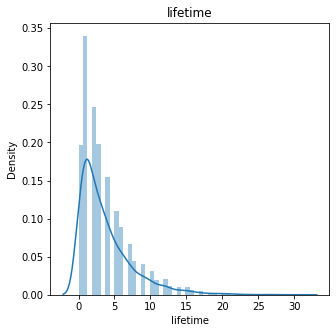

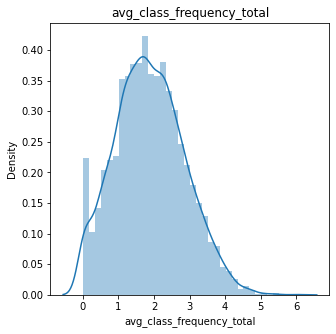

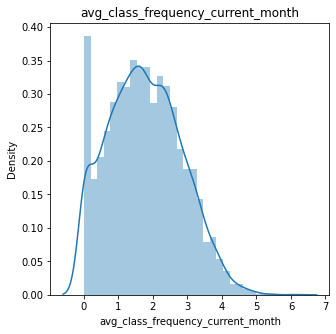

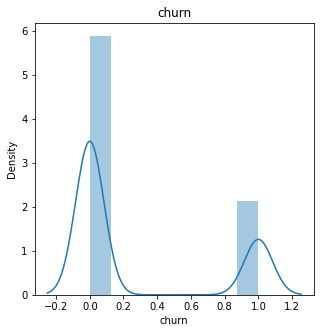

In [38]:
for column in df.columns:
    plt.figure(figsize=(5, 5))
    df.groupby('churn')[column]
    sns.distplot(df[column])
    plt.title(column)
    plt.show()

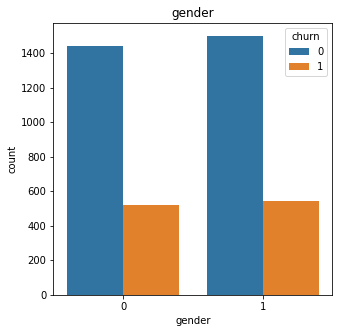

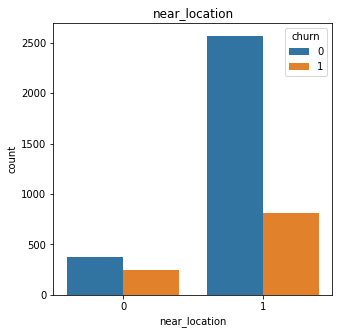

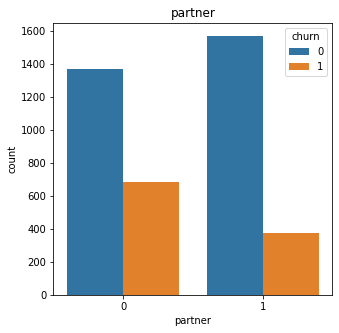

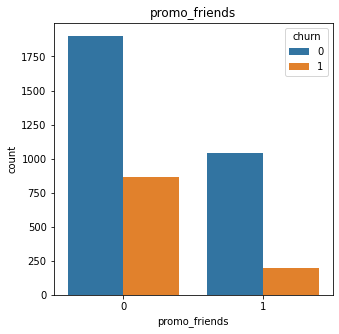

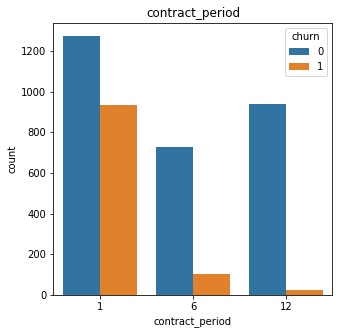

In [39]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='churn', data=df)
    plt.title(column)
    plt.show()

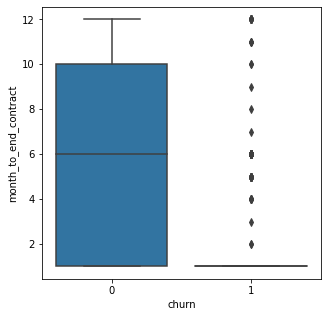

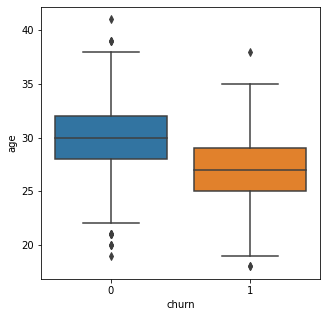

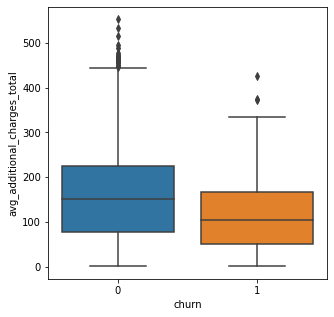

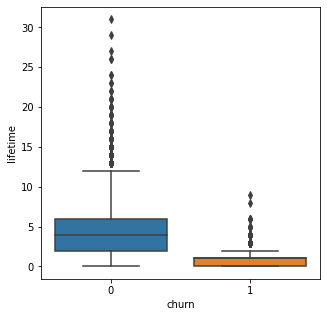

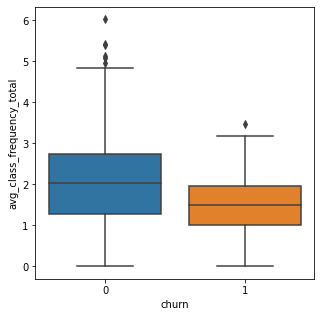

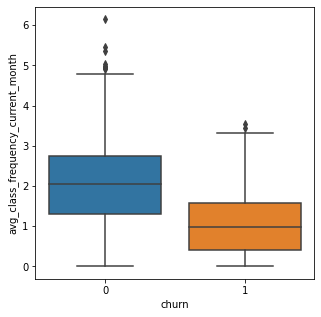

In [40]:

for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'churn', y = df[column], data = df)
    plt.show()

Исходя из графиков выше:
* Пол особо не виляет на отток
* Естественно, чем дольше контракт, тем меньше отток.
* Промо "приведи друга" явно работает, отток клиентов меньше у тех, кто ходит в зал с "друзьями"
* "Партнеры" тоже хорошо влияют на общую картину
* Локация клиентов тоже играет важную роль - никому не хочется ехать в другой район для занятий.
* Чем чаще пользователь посещает занятия, тем меньше шансов того, что он уйдет.
* Труднее всего удержать клиентов младшего возраста.

Проверим корреляцию:

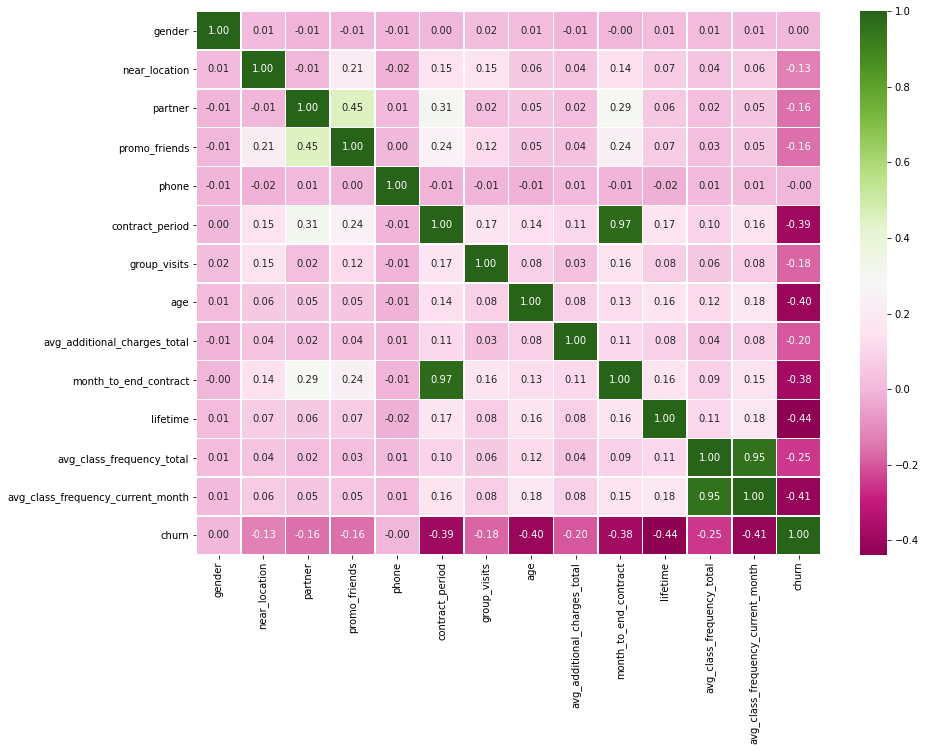

In [41]:
cm = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5, cmap="PiYG")
plt.show()

Краткие выводы по карте корреляции:

* Пол и телефон имеет нулевую корреляцию
* Есть мультиколлинеарные признаки:

    1) contract_period - month_to_end_contract
    
    2) avg_class_frequency_current_month - avg_class_frequency_total

## Построение модели прогнозирования оттока пользователей

In [42]:
X = df.drop('churn', axis = 1)
y = df['churn']

### Логистическая регрессия

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
model = LogisticRegression()

In [45]:
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [47]:

print('Accuracy | Нет баланса классов: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy | Нет баланса классов: 0.91
Precision: 0.82
Recall: 0.80
F1: 0.81


### Случайный лес

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [49]:

print('Accuracy | Нет баланса классов: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy | Нет баланса классов: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


Лучше себя показала вторая модель.

## Кластеризация пользователей.

In [50]:
df_sс = df.drop(['churn'], axis=1)
df_columns_list = df_sс.columns
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')

In [51]:
linked = linkage(df_sс, method = 'ward')

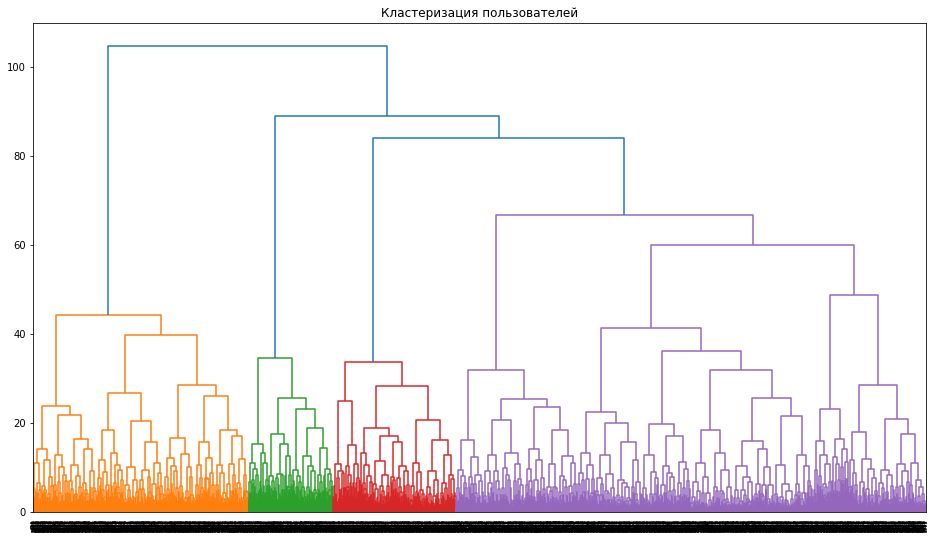

In [53]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Можно разделить на 5 явных кластеров.

In [54]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(df_sс)
df['cluster'] = labels

In [55]:
df.cluster.value_counts()

3    1115
4     935
2     765
0     643
1     542
Name: cluster, dtype: int64

In [58]:
display(df.groupby(['cluster']).mean().T.round(2))

cluster,0,1,2,3,4
gender,0.49,0.50,0.59,0.49,0.50
near_location,1.00,0.00,0.97,1.00,0.94
partner,0.82,0.47,0.26,0.25,0.74
promo_friends,1.00,0.08,0.10,0.02,0.49
phone,0.90,0.92,0.91,0.90,0.90
contract_period,3.14,2.21,2.84,1.99,11.88
group_visits,0.46,0.22,0.48,0.32,0.55
age,29.19,28.47,30.18,28.23,29.92
avg_additional_charges_total,141.22,133.68,162.50,130.98,164.89
month_to_end_contract,2.91,2.08,2.61,1.90,10.88


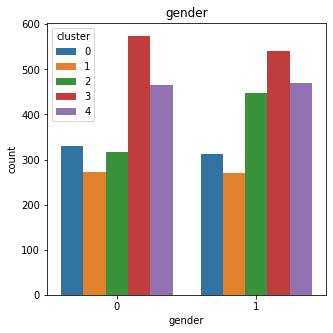

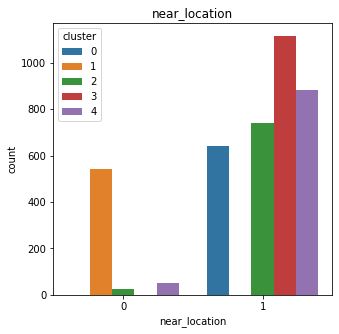

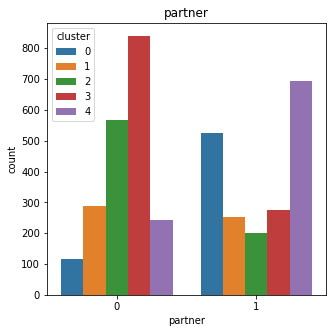

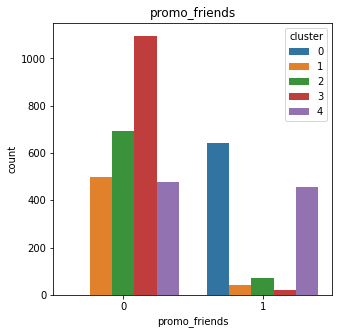

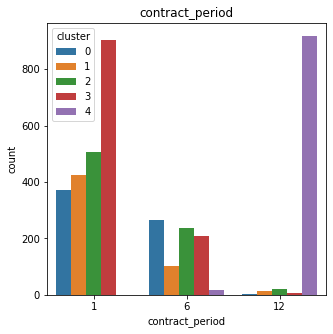

In [59]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='cluster', data=df)
    plt.title(column)
    plt.show()

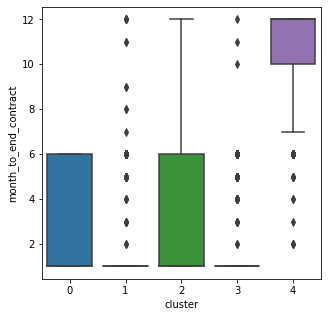

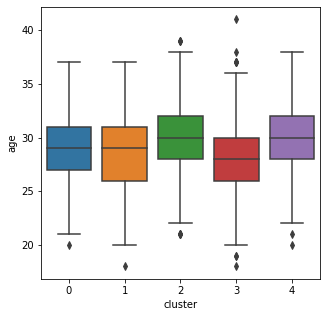

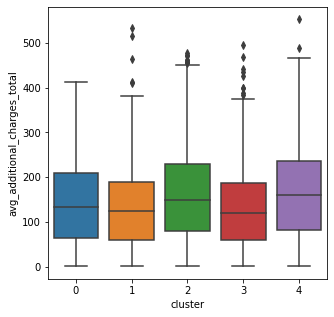

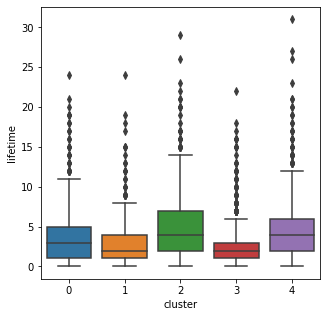

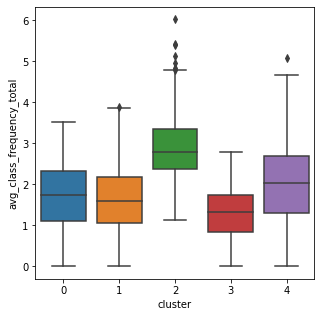

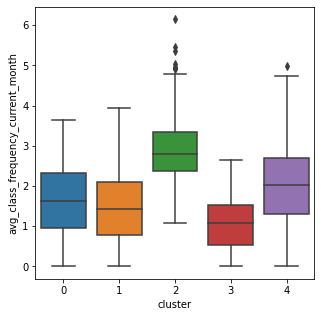

In [61]:
for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster', y = df[column], data = df)
    plt.show()

В среднем слабее оттекают кластеры №2 и №4;

Кластеры не равнозначны по количеству клиентов и по доле оттока;

Быстрее всего оттекают клиенты из кластера №3 и №1.


Признаки `хороших кластеров`:
* возраст - клиенты в нем старше
* 4 кластер выделяется длительностью абонемента
* оба кластера выделяются временем с момента первого обращения — ходят давно
* большими расходами на доп. услуги
* средняя частота посещений в неделю за предыдущий месяц у них тоже выже


## Общие выводы:

* Для закупки трафика и привлечения пользователей использовать лук-элайк аудитории из "хороших кластеров".
* Поддерживать и мотивировать "хорошие кластеры".
* Провести более подробный анализ оттекающих, чтобы выявить возможные индивидуальные предложения для уменьшения оттока.
* Смотреть на данные не в ретроспективе, а выстроить систему предикативной аналитики и стараться прогнозировать такие моменты заранее.

## Рекомендации

Несколько идей и рекомендаций для удержания клиентов:
* Промо "приведи друга" хорошо себя показало, стоит посмотреть и придумать, какое промо еще можно ввести, чтобы завлечь больше клиентов и удержать их.
* Для напоминания и мотивация похода в зал - обзавестить приложением клуба, возможные фичи в нём, тем самым геймефицировать процесс(чтобы удержать более молодых клиентов и мотивировать на более частые походы с зал):
    1) Достижения в приложении - таким образом можно поставить "цель", которую необходимо достигнуть. Можно добавить статистику и показать, у какого % пользователей есть такое достижение.
    
    2) Синхронизация данных из приложения с данными из основных приложений телефона отслеживающих активность.
    
    3) Возможность использовать приложение, как трекер для занятий(с внесением дистанции, веса, кол-ва повторений)
    
    4) Введение "онлайн соревнований", которые длятся несколько дней(с учетом выполнения п.3), чтобы при участии в нем и заняв лидирующую позицию - клиент был заинтереован в том, чтобы удержать ее, а другие в том, чтобы занять ее. Можно даже не мотивировать пользователей каким-то ценным призом - важен сам процесс.